Name: Rizvana Hredita

#Libraries added

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sb
import datetime as dt

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import *
from keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from keras.utils import losses_utils
from keras import backend

#Eutrophication Modelling

A two layer Bidirectional LSTM model is prepared to forecast the levels of chl-a in a water body. 

In [4]:
CH=pd.read_csv("/content/chl_a_data.csv")
CH.columns

Index(['Year', 'Lake', 'DoY', 'BGA_YSI', 'BGA_HYLB', 'BGA_logged_YSI',
       'BGA_logged_HYLB', 'DO_YSI', 'DO_HYLB', 'DOsat_calc_YSI',
       'DOsat_calc_HYLB', 'PH_YSI', 'PH_HYLB', 'Chl_YSI', 'Chl_HYLB',
       'Temp_YSI', 'Temp_HYLB'],
      dtype='object')

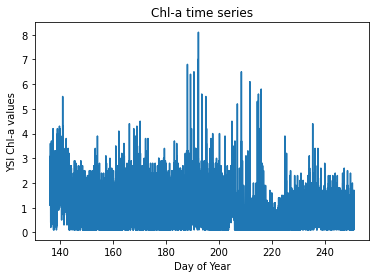

In [5]:
condition1=CH.Year==2014 #one out of 2013,2014 and 2015
condition2=CH.Lake=='L' #one out of L, R, T
CH1=CH.loc[condition1 & condition2,['DoY','Chl_YSI']]
plt.plot(CH1.DoY,CH1.Chl_YSI)
plt.title('Chl-a time series')
plt.xlabel('Day of Year')
plt.ylabel('YSI Chl-a values')
plt.show()

Calculation of moving average to minimize fluctuations, followed by min=max scaling. Scaling is part of data preprocessing for neural networks. The previous day Chl-a is also used in the model.

In [6]:
CH1.loc[:,'mavg']=CH1.Chl_YSI.rolling(15).mean()
CH1.loc[:,'mavg']=(CH1.mavg-CH1.mavg.min())/(CH1.mavg.max()-CH1.mavg.min())
CH1.loc[:,'Forecast1']=CH1['mavg'].shift(1) #past values

Splitting data into training and testing

In [7]:
CH1.dropna(inplace=True)
X=CH1
X_train=CH1.iloc[0:3301].reset_index(drop=True,inplace=False)
X_test=CH1.iloc[3301:].reset_index(drop=True,inplace=False)

In [8]:
train_data = X_train.loc[:,['Forecast1']]
train_target = X_train.loc[:,['mavg']]
test_data = X_test.loc[:,['Forecast1']]
test_target = X_test.loc[:,['mavg']]
all_data = X.loc[:,['Forecast1']]
all_target = X.loc[:,['mavg']]

In [9]:
train_data = train_data.to_numpy().reshape(train_data.shape[0],train_data.shape[1],1)
test_data = test_data.to_numpy().reshape(test_data.shape[0],test_data.shape[1],1)
model = keras.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(200, activation='relu', return_sequences=True, input_shape=(train_data.shape[1],1))))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(15, activation='relu', return_sequences=False)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

earlyStopping = EarlyStopping(monitor='loss', patience=9, verbose=0, mode='min')
mcp_save = ModelCheckpoint('best_model_yet.hdf5', save_best_only=True, monitor='loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=7, verbose=1, mode='min')

model.compile(
    loss=keras.losses.mae,
    optimizer='Adam',
    metrics=MeanAbsolutePercentageError())
model.fit(train_data, train_target, epochs=300, callbacks=[earlyStopping, mcp_save, reduce_lr_loss])
   

Epoch 1/300
104/104 [==============================] - 5s 7ms/step - loss: 0.1519 - mean_absolute_percentage_error: 66.2558 - lr: 0.0010
Epoch 2/300
104/104 [==============================] - 1s 7ms/step - loss: 0.0773 - mean_absolute_percentage_error: 30.4294 - lr: 0.0010
Epoch 3/300
104/104 [==============================] - 1s 7ms/step - loss: 0.0127 - mean_absolute_percentage_error: 4.3380 - lr: 0.0010
Epoch 4/300
104/104 [==============================] - 1s 7ms/step - loss: 0.0128 - mean_absolute_percentage_error: 4.3758 - lr: 0.0010
Epoch 5/300
104/104 [==============================] - 1s 7ms/step - loss: 0.0120 - mean_absolute_percentage_error: 4.1120 - lr: 0.0010
Epoch 6/300
104/104 [==============================] - 1s 7ms/step - loss: 0.0118 - mean_absolute_percentage_error: 4.0461 - lr: 0.0010
Epoch 7/300
104/104 [==============================] - 1s 7ms/step - loss: 0.0119 - mean_absolute_percentage_error: 4.0432 - lr: 0.0010
Epoch 8/300
104/104 [=========================

In [10]:
all_data = all_data.to_numpy().reshape(all_data.shape[0],all_data.shape[1],1)

Generating predictions for model assessment

In [11]:
import math
yhat = model.predict(all_data)
predicted=[float(ele[0]) for ele in yhat]
from sklearn.metrics import mean_squared_error
MS=math.sqrt(mean_squared_error(all_target['mavg'],predicted))
print('RMSE: %.3f' % MS)

1035/1035 [==============================] - 2s 2ms/step
RMSE: 0.022


The low RMSE is encouraging, the superimposition of actual and predicted shows good forecasts.

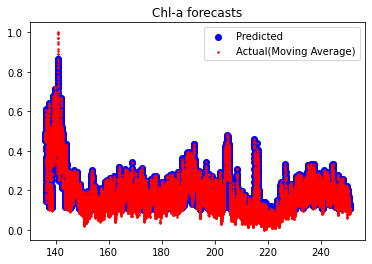

In [12]:
p1=plt.scatter(X.DoY,predicted,c='blue')
p2=plt.scatter(X.DoY,X.mavg,c='red',s=2)
plt.legend((p1,p2),('Predicted','Actual(Moving Average)'))
plt.title('Chl-a forecasts')
plt.show()

In [13]:
Dpred=pd.DataFrame({'DoY':X.DoY,'Predicted':predicted,'Actual':X['Chl_YSI']},
                   columns=['DoY','Predicted','Actual'])
Dpred['Predicted']=(Dpred['Predicted'] *(X['Chl_YSI'].max()-X['Chl_YSI'].min())+X['Chl_YSI'].min())
Dpred.head()

,DoY,Predicted,Actual
32559,136.052083,3.725113,2.2
32560,136.055556,3.751959,2.3
32561,136.059028,3.844527,1.6
32562,136.062500,3.818303,2.3
32563,136.065972,3.818303,1.6


In [14]:
Dpred.to_csv("bilstm_chlapred.csv",index=False)